# Global Weather Analysis
### PM Accelerator Mission:
By making industry-leading tools and education available to individuals from all backgrounds, we level the playing field for future PM leaders. This is the PM Accelerator motto, as we grant aspiring and experienced PMs what they need most – Access. We introduce you to industry leaders, surround you with the right PM ecosystem, and discover the new world of AI product management skills.

## Library Installation and Import

In [67]:
!pip install -r ../requirements.txt

time: 183 µs (started: 2025-01-16 02:35:17 +00:00)


In [3]:
import os
import zipfile
import csv
import string
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random 

import folium
import pandas as pd
from folium.plugins import HeatMap
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, hamming_loss
from sklearn.multiclass import OneVsRestClassifier as OVR
from sklearn.naive_bayes import MultinomialNB, ComplementNB, CategoricalNB
from sklearn.svm import LinearSVC

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam

2025-01-16 01:13:09.879887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 01:13:09.879995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 01:13:09.969168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 01:13:10.167457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 01:13:11.857117: W tensorflow/compiler/tf2

In [4]:
SEED = 99
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
random_seed(SEED)
%load_ext autotime
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print("CUDA Version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN Version:", tf.sysconfig.get_build_info()["cudnn_version"])

TensorFlow version: 2.15.0
CUDA Version: 12.2
cuDNN Version: 8
time: 11 ms (started: 2025-01-16 01:13:13 +00:00)


## Data Cleaning & Preprocessing

In [5]:
df = pd.read_csv("/notebooks/data/GlobalWeatherRepository.csv")
df

country     location_name  latitude  longitude         timezone  \
0      Afghanistan             Kabul   34.5200    69.1800       Asia/Kabul   
1          Albania            Tirana   41.3300    19.8200    Europe/Tirane   
2          Algeria           Algiers   36.7600     3.0500   Africa/Algiers   
3          Andorra  Andorra La Vella   42.5000     1.5200   Europe/Andorra   
4           Angola            Luanda   -8.8400    13.2300    Africa/Luanda   
...            ...               ...       ...        ...              ...   
47352    Venezuela           Caracas   10.5000   -66.9167  America/Caracas   
47353      Vietnam             Hanoi   21.0333   105.8500     Asia/Bangkok   
47354        Yemen             Sanaa   15.3547    44.2067        Asia/Aden   
47355       Zambia            Lusaka  -15.4167    28.2833    Africa/Lusaka   
47356     Zimbabwe            Harare  -17.8178    31.0447    Africa/Harare   

       last_updated_epoch      last_updated  temperature_celsius  \
0              1715849100  2024-05-16 13:15                 26.6   
1              1715849100  2024-05-16 10:45                 19.0   
2              1715849100  2024-05-16 09:45                 23.0   
3              1715849100  2024-05-16 10:45                  6.3   
4              1715849100  2024-05-16 09:45                 26.0   
...                   ...               ...                  ...   
47352          1736934300  2025-01-15 05:45                 15.5   
47353          1736936100  2025-01-15 17:15                 23.1   
47354          1736937000  2025-01-15 13:30                 18.9   
47355          1736937000  2025-01-15 12:30                 28.0   
47356          1736937000  2025-01-15 12:30                 25.6   

       temperature_fahrenheit      condition_text  ...  air_quality_PM2.5  \
0                        79.8       Partly Cloudy  ...              8.400   
1                        66.2       Partly cloudy  ...              1.100   
2                        73.4               Sunny  ...             10.400   
3                        43.3       Light drizzle  ...              0.700   
4                        78.8       Partly cloudy  ...            183.400   
...                       ...                 ...  ...                ...   
47352                    60.0          Light rain  ...              2.590   
47353                    73.6               Sunny  ...             68.635   
47354                    66.0               Sunny  ...             26.455   
47355                    82.4       Partly Cloudy  ...             15.355   
47356                    78.1  Patchy rain nearby  ...             17.575   

       air_quality_PM10  air_quality_us-epa-index air_quality_gb-defra-index  \
0                26.600                         1                          1   
1                 2.000                         1                          1   
2                18.400                         1                          1   
3                 0.900                         1                          1   
4               262.300                         5                         10   
...                 ...                       ...                        ...   
47352             2.960                         1                          1   
47353            69.005                         4                          9   
47354            69.745                         2                          3   
47355            15.355                         1                          2   
47356            17.760                         2                          2   

        sunrise    sunset  moonrise   moonset      moon_phase  \
0      04:50 AM  06:50 PM  12:12 PM  01:11 AM  Waxing Gibbous   
1      05:21 AM  07:54 PM  12:58 PM  02:14 AM  Waxing Gibbous   
2      05:40 AM  07:50 PM  01:15 PM  02:14 AM  Waxing Gibbous   
3      06:31 AM  09:11 PM  02:12 PM  03:31 AM  Waxing Gibbous   
4      06:12 AM  05:55 PM  01:17 PM  12:38 AM 

time: 243 ms (started: 2025-01-16 01:13:13 +00:00)


### Check Missing Values

In [6]:
missing_values=df.isnull().sum()
print("Missing values:\n", missing_values)
missing_values = df.isnull().sum().sum()
# Check if there are any missing values and print the result using print statement
if missing_values > 0:
    print(f"Missing values are present. Total missing values: {missing_values}")
else:
    print(f"No missing values are present in the Dataset.")

Missing values:
 country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone              

### Check Duplicated Values

In [7]:
duplicates_count = df.duplicated().sum()

# Check if there are any duplicate rows and print the result using f-strings
if df.duplicated().any():
    print(f"Duplicates are present. Total duplicate rows: {duplicates_count}")
else:
    print(f"No duplicates are present in the Dataset.")

No duplicates are present in the Dataset.
time: 82.2 ms (started: 2025-01-16 01:13:13 +00:00)


### Check Infinity Values

In [8]:
# Check for inf values in numeric columns only
numeric_columns = df.select_dtypes(include=[np.number]).columns
inf_values_count = np.isinf(df[numeric_columns]).sum().sum()

# Check if there are any inf values and print the result
if inf_values_count > 0:
    print(f"Inf values are present. Total inf values: {inf_values_count}")
else:
    print(f"No inf values are present in the Dataset.")

No inf values are present in the Dataset.
time: 7.74 ms (started: 2025-01-16 01:13:13 +00:00)


### Outlier Detection and Boxplot Visualization

This process involves detecting and removing outliers using the IQR (Interquartile Range) method, followed by boxplot visualization to understand the cleaned dataset.

* **Data Selection and Preparation**
  - Identifies numeric columns in the DataFrame using `select_dtypes()`
  - Creates an initial boolean mask for tracking outliers across all columns

* **Outlier Detection**
  - Calculates Q1 (25th percentile) and Q3 (75th percentile) for each numeric column
  - Computes IQR (Interquartile Range) and defines outlier boundaries using the 1.5 * IQR rule
  - Marks data points outside these boundaries as outliers in the mask

* **Data Cleaning**
  - Creates a new DataFrame `df_no_outliers` by filtering out the identified outliers using the mask

* **Visualization Setup**
  - Calculates the required number of rows and columns for subplot layout
  - Creates a figure with appropriate plot which is maximum of 5 plots per row.

* **Boxplot Creation**
  - Generates boxplots for each numeric column in the cleaned dataset
  - Adds red dashed lines for lower bounds and blue dashed lines for upper bounds
  - Includes titles and legend for each subplot
  - Uses `tight_layout()` for proper spacing and displays the plots

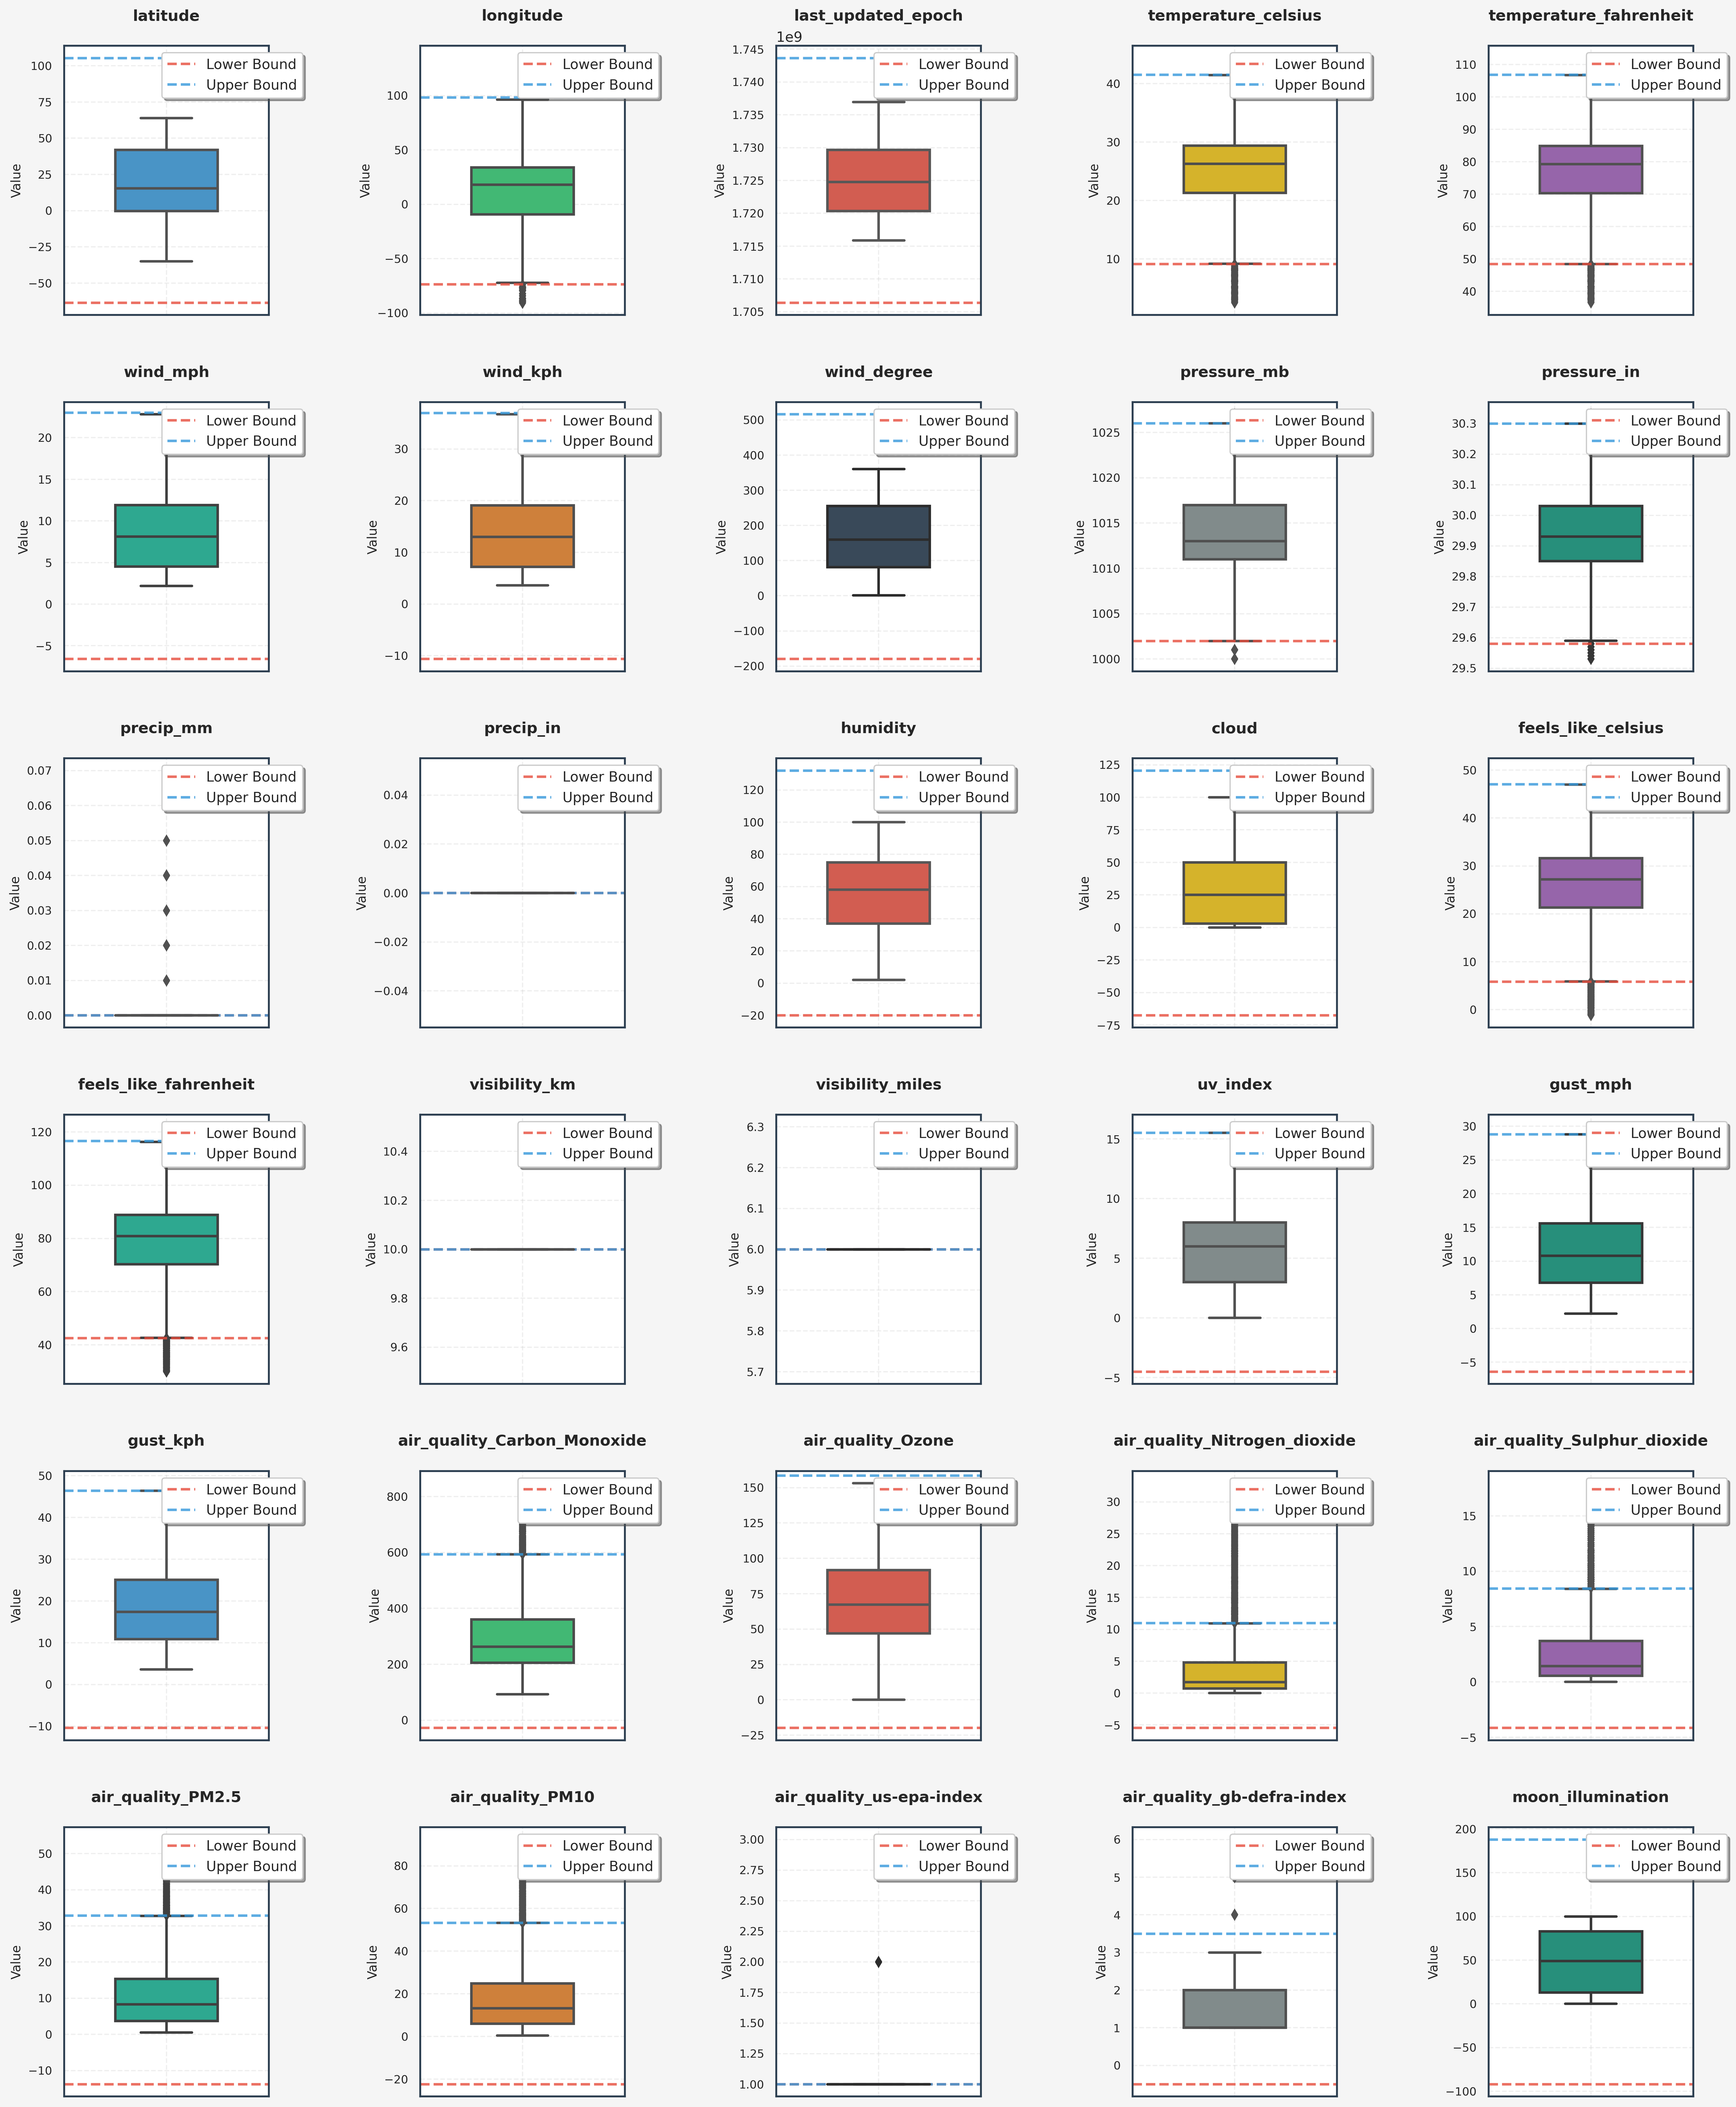

<Figure size 640x480 with 0 Axes>

time: 5.09 s (started: 2025-01-16 02:01:36 +00:00)


In [54]:
# Select numeric columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Create a boolean mask for outliers
outlier_mask = pd.Series(False, index=df.index)

# Calculate IQR and identify outliers
for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Update the outlier mask
    outlier_mask |= (df[column] < lower_bound) | (df[column] > upper_bound)

# Create a new DataFrame without outliers
df_no_outliers = df[~outlier_mask]
df_no_outliers = df_no_outliers.reset_index()

# Set custom color palette
custom_palette = ['#3498db', '#2ecc71', '#e74c3c', '#f1c40f', '#9b59b6', 
                 '#1abc9c', '#e67e22', '#34495e', '#7f8c8d', '#16a085']

# Set up the matplotlib figure with a light background
plt.rcParams['figure.facecolor'] = '#f5f5f5'
plt.rcParams['axes.facecolor'] = 'white'

# Create figure
num_cols = 5
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
fig = plt.figure(figsize=(20, num_rows * 4), dpi=300)

# Create boxplots for the DataFrame without outliers
for i, column in enumerate(numerical_columns):
    Q1 = df_no_outliers[column].quantile(0.25)
    Q3 = df_no_outliers[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ax = plt.subplot(num_rows, num_cols, i + 1)
    
    # Create boxplot with custom style
    bp = sns.boxplot(y=df_no_outliers[column], 
                    color=custom_palette[i % len(custom_palette)],
                    width=0.5,
                    linewidth=2,
                    fliersize=5,
                    showfliers=True)
    
    # Customize the box properties
    for box in bp.artists:
        box.set_alpha(0.7)
        box.set_edgecolor('black')
    
    # Add lines for bounds with enhanced style
    plt.axhline(y=lower_bound, color='#e74c3c', linestyle='--', 
                linewidth=2, label='Lower Bound', alpha=0.8)
    plt.axhline(y=upper_bound, color='#3498db', linestyle='--', 
                linewidth=2, label='Upper Bound', alpha=0.8)
    
    # Enhanced title and labels
    plt.title(column, pad=20, fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Value', fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Customize spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#2c3e50')
    
    # Add the legend with enhanced style
    legend = plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1),
                       frameon=True, fancybox=True, shadow=True)
    
    # Adjust tick parameters
    plt.tick_params(axis='both', which='major', labelsize=9)

# Adjust layout and display
plt.tight_layout(pad=3.0)
plt.show()
plt.savefig('../output/visuals/features_boxplot.png', dpi=300, bbox_inches='tight')

###  Print summary of outlier removal

In [10]:
print(f"Original dataset shape: {df.shape}")
print(f"Shape after removing outliers: {df_no_outliers.shape}")
print(f"Number of rows removed: {df.shape[0] - df_no_outliers.shape[0]}")
print(f"Outliers detected: {outlier_mask.sum()}")

Original dataset shape: (47357, 41)
Shape after removing outliers: (20114, 42)
Number of rows removed: 27243
Outliers detected: 27243
time: 966 µs (started: 2025-01-16 01:13:19 +00:00)


In [11]:
df_no_outliers

index              country  location_name  latitude  longitude  \
0          0          Afghanistan          Kabul   34.5200    69.1800   
1          5  Antigua and Barbuda   Saint John's   17.1200   -61.8500   
2          6            Argentina   Buenos Aires  -34.5900   -58.6700   
3          9              Austria         Vienna   48.2000    16.3700   
4         10           Azerbaijan           Baku   40.4000    49.8800   
...      ...                  ...            ...       ...        ...   
20109  47334             Tanzania         Dodoma   -6.1833    35.7500   
20110  47339  Trinidad and Tobago  Port Of Spain   10.6500   -61.5167   
20111  47349              Uruguay     Montevideo  -34.8581   -56.1708   
20112  47354                Yemen          Sanaa   15.3547    44.2067   
20113  47355               Zambia         Lusaka  -15.4167    28.2833   

                             timezone  last_updated_epoch      last_updated  \
0                          Asia/Kabul          1715849100  2024-05-16 13:15   
1                     America/Antigua          1715849100  2024-05-16 04:45   
2      America/Argentina/Buenos_Aires          1715849100  2024-05-16 05:45   
3                       Europe/Vienna          1715849100  2024-05-16 10:45   
4                           Asia/Baku          1715849100  2024-05-16 12:45   
...                               ...                 ...               ...   
20109            Africa/Dar_es_Salaam          1736937000  2025-01-15 13:30   
20110           America/Port_of_Spain          1736937000  2025-01-15 06:30   
20111              America/Montevideo          1736940600  2025-01-15 08:30   
20112                       Asia/Aden          1736937000  2025-01-15 13:30   
20113                   Africa/Lusaka          1736937000  2025-01-15 12:30   

       temperature_celsius  temperature_fahrenheit  ... air_quality_PM2.5  \
0                     26.6                    79.8  ...             8.400   
1                     26.0                    78.8  ...             1.200   
2                      8.0                    46.4  ...             4.000   
3                     16.0                    60.8  ...             3.700   
4                     17.0                    62.6  ...             1.900   
...                    ...                     ...  ...               ...   
20109                 27.2                    81.0  ...            13.320   
20110                 22.4                    72.3  ...            10.915   
20111                 22.2                    72.0  ...            10.545   
20112                 18.9                    66.0  ...            26.455   
20113                 28.0                    82.4  ...            15.355   

       air_quality_PM10  air_quality_us-epa-index  air_quality_gb-defra-index  \
0                26.600                         1                           1   
1                 4.500                         1                           1   
2                 5.300                         1                           1   
3                 4.400                         1                           1   
4                 2.200                         1                           1   
...                 ...                       ...                         ...   
20109            15.540                         1                           2   
20110            15.910                         1                           1   
20111            13.135                         1                           1   
20112            69.745                         2                           3   
20113            15.355                         1                           2   

        sunrise    sunset  moonrise   moonset      moon_phase  \
0      04:50 AM  06:50 PM  12:12 PM  01:11 AM  Waxing Gibbous   
1      05:36 AM  06:32 PM  01:05 PM  01:14 AM  Waxing Gibbous   
2      07:43 AM  05:59 PM  02:36 PM  01:04 AM  Waxing Gibbous   
3      05:14 AM  08:29 

time: 19.2 ms (started: 2025-01-16 01:13:19 +00:00)


## Exploratory Data Analysis (EDA)

### Get summary statistics

In [12]:
print(df_no_outliers.describe())

              index      latitude     longitude  last_updated_epoch  \
count  20114.000000  20114.000000  20114.000000        2.011400e+04   
mean   21088.637317     18.757638      9.237831        1.725244e+09   
std    12880.075996     25.750078     47.464237        5.788978e+06   
min        0.000000    -34.860000    -90.530000        1.715849e+09   
25%    10352.750000     -0.216700     -9.130000        1.720357e+09   
50%    19926.500000     15.354700     18.050000        1.724762e+09   
75%    30929.750000     42.000000     33.780000        1.729675e+09   
max    47355.000000     63.830000    134.557800        1.736941e+09   

       temperature_celsius  temperature_fahrenheit      wind_mph  \
count         20114.000000            20114.000000  20114.000000   
mean             25.080392               77.145913      8.491136   
std               7.080302               12.744840      4.665866   
min               2.500000               36.500000      2.200000   
25%              21.

In [13]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20114 entries, 0 to 20113
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         20114 non-null  int64  
 1   country                       20114 non-null  object 
 2   location_name                 20114 non-null  object 
 3   latitude                      20114 non-null  float64
 4   longitude                     20114 non-null  float64
 5   timezone                      20114 non-null  object 
 6   last_updated_epoch            20114 non-null  int64  
 7   last_updated                  20114 non-null  object 
 8   temperature_celsius           20114 non-null  float64
 9   temperature_fahrenheit        20114 non-null  float64
 10  condition_text                20114 non-null  object 
 11  wind_mph                      20114 non-null  float64
 12  wind_kph                      20114 non-null  float64
 13  w

### Correlation Heatmap

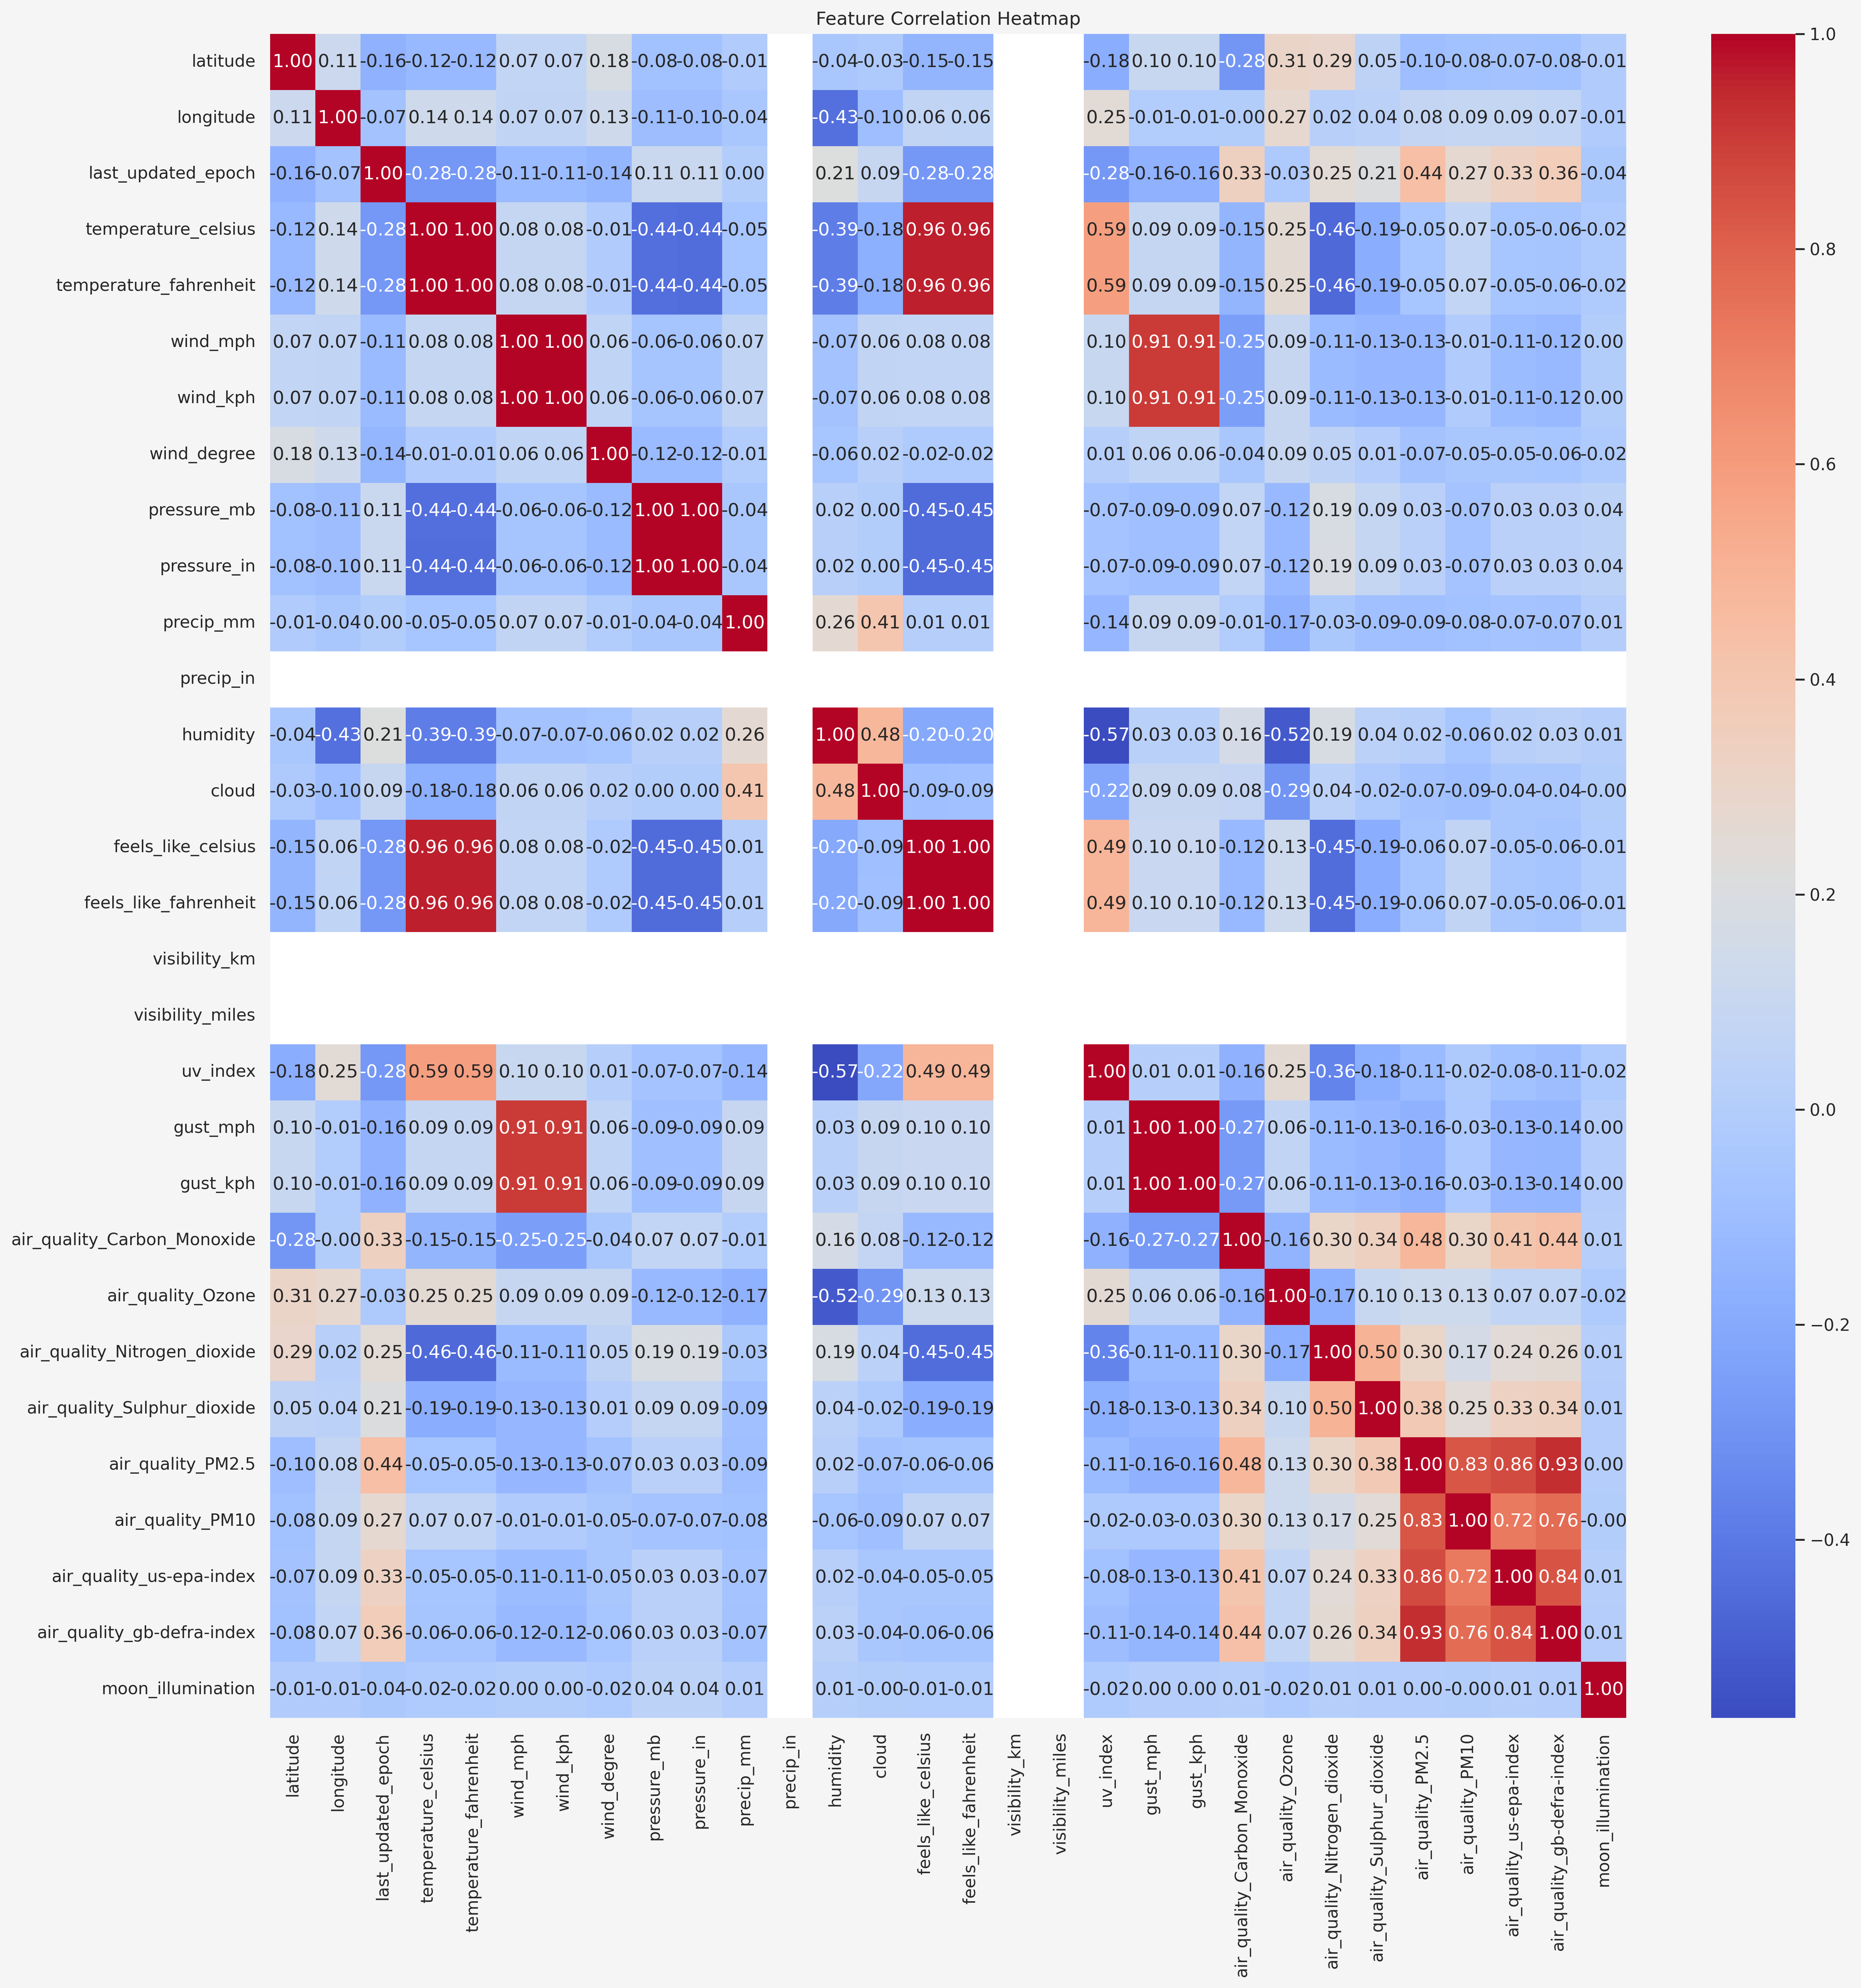

<Figure size 640x480 with 0 Axes>

time: 2.69 s (started: 2025-01-16 02:06:05 +00:00)


In [61]:
df_numeric = df_no_outliers[numerical_columns]
plt.figure(figsize=(20, 20), dpi=300)
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True, linewidths=0, linecolor='white')
plt.title("Feature Correlation Heatmap")
plt.grid(False)
plt.show()
plt.savefig('../output/visuals/corr_heatmap.png', dpi=300, bbox_inches='tight')

### Use 'last_updated' as index
use last_update as index time series and drop unnecessary columns such as 'index', 'last_updated_epoch'

In [63]:
# Convert 'last_updated' to datetime format
df_no_outliers['last_updated'] = pd.to_datetime(df_no_outliers['last_updated'])

# Extracting temporal features
df_no_outliers['year'] = df_no_outliers['last_updated'].dt.year
df_no_outliers['month'] = df_no_outliers['last_updated'].dt.month
df_no_outliers['day'] = df_no_outliers['last_updated'].dt.day
df_no_outliers['hour'] = df_no_outliers['last_updated'].dt.hour

# Set 'last_updated' as the index
df_no_outliers.set_index('last_updated', inplace=True)

# Sort by index if needed
df_no_outliers.sort_index(inplace=True)

# Drop columns
df_no_outliers = df_no_outliers.drop(columns=['index', 'last_updated_epoch'])

# Display the result
df_no_outliers

country   location_name  latitude  longitude  \
last_updated                                                            
2024-05-16 02:45:00    Nicaragua         Managua   12.1500   -86.2700   
2024-05-16 02:45:00       Belize        Belmopan   17.2500   -88.7700   
2024-05-16 03:45:00       Panama     Panama City    8.9700   -79.5300   
2024-05-16 03:45:00         Peru            Lima  -12.0500   -77.0500   
2024-05-16 04:45:00      Grenada  Saint George's   12.0500   -61.7500   
...                          ...             ...       ...        ...   
2025-01-15 15:15:00     Maldives       Dhidhdhoo    6.8833    73.1000   
2025-01-15 15:45:00       Bhutan         Thimphu   27.4833    89.6000   
2025-01-15 16:45:00     Thailand             Nan   18.7833   100.7833   
2025-01-15 17:30:00     Cambodia      Phnom Penh   11.5500   104.9167   
2025-01-15 19:15:00  Philippines          Manila   14.6042   120.9822   

                            timezone  temperature_celsius  \
last_updated                                                
2024-05-16 02:45:00  America/Managua                 27.2   
2024-05-16 02:45:00   America/Belize                 26.0   
2024-05-16 03:45:00   America/Panama                 26.0   
2024-05-16 03:45:00     America/Lima                 16.6   
2024-05-16 04:45:00  America/Grenada                 28.0   
...                              ...                  ...   
2025-01-15 15:15:00  Indian/Maldives                 27.2   
2025-01-15 15:45:00     Asia/Thimphu                 11.0   
2025-01-15 16:45:00     Asia/Bangkok                 28.2   
2025-01-15 17:30:00  Asia/Phnom_Penh                 31.2   
2025-01-15 19:15:00      Asia/Manila                 26.6   

                     temperature_fahrenheit      condition_text  wind_mph  \
last_updated                                                                
2024-05-16 02:45:00                    80.9  Patchy rain nearby       3.6   
2024-05-16 02:45:00                    78.9            Overcast       4.3   
2024-05-16 03:45:00                    78.8            Overcast       2.2   
2024-05-16 03:45:00                    61.9       Partly Cloudy       7.4   
2024-05-16 04:45:00                    82.4       Partly cloudy      13.6   
...                                     ...                 ...       ...   
2025-01-15 15:15:00                    80.9            Overcast      14.5   
2025-01-15 15:45:00                    51.7               Sunny       5.8   
2025-01-15 16:45:00                    82.8               Sunny       2.5   
2025-01-15 17:30:00                    88.2       Partly cloudy       8.9   
2025-01-15 19:15:00                    79.9  Patchy rain nearby       7.2   

                     wind_kph  ...   sunrise    sunset  moonrise   moonset  \
last_updated                   ...                                           
2024-05-16 02:45:00       5.8  ...  05:21 AM  06:02 PM  12:49 PM  12:49 AM   
2024-05-16 02:45:00       6.8  ...  05:23 AM  06:20 PM  12:56 PM  01:04 AM   
2024-05-16 03:45:00       3.6  ...  05:58 AM  06:31 PM  01:24 PM  01:18 AM   
2024-05-16 03:45:00      11.9  ...  06:18 AM  05:51 PM  01:30 PM  12:47 AM   
2024-05-16 04:45:00      22.0  ...  05:43 AM  06:24 PM  01:08 PM  01:08 AM   
...                       ...  ...       ...       ...       ...       ...   
2025-01-15 15:15:00      23.4  ...  06:24 AM  06:10 PM  07:36 PM  07:31 AM   
2025-01-15 15:45:00       9.4  ...  06:53 AM  05:29 PM  06:53 PM  08:01 AM   
2025-01-15 16:45:00       4.0  ...  06:53 AM  06:00 PM  07:23 PM  07:58 AM   
2025-01-15 17:30:00      14.4  ...  06:24 AM  05:56 PM  07:17 PM  07:28 AM   
2025-01-15 19:15:00      11.5  ...  06:25 AM  05:46 PM  07:05 PM  07:27 AM   

                         moon_phase  moon_illumination  year  month  day  hour  
last_updated                                                                    
2024-05-16 02:45:00  Waxing Gibbous                 55  2024      5   16     2  
2024-05-16 02:45:00  

time: 77.4 ms (started: 2025-01-16 02:10:52 +00:00)


### Daily Global Temperature (Celsius) Trends

/tmp/ipykernel_793/809526091.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily = df_daily.fillna(method='ffill')


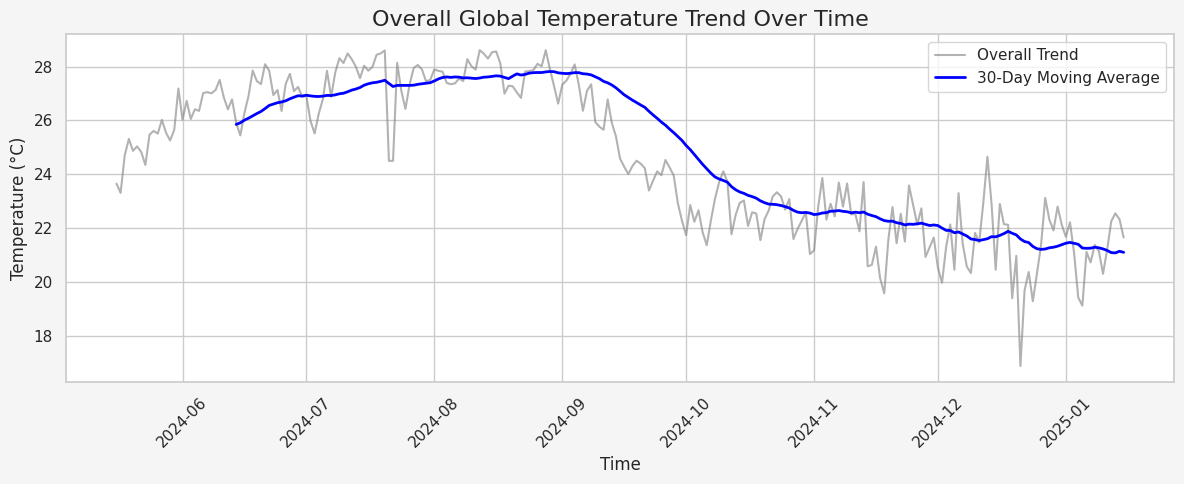

<Figure size 640x480 with 0 Axes>

time: 416 ms (started: 2025-01-16 02:11:27 +00:00)


In [66]:
# Filter for object columns
object_columns = df_no_outliers.select_dtypes(include='object')

# Resample to daily frequency by taking the mean of the temperature for each day
df_daily = df_no_outliers.drop(columns=object_columns)

df_daily = df_daily.resample('D').mean()

# Calculate the mean of the temperature celcius series (ignoring NaN)
mean_value = df_daily['temperature_celsius'].mean()

# Replace the specific value 7.1 with the mean
df_daily = df_daily.replace(7.1, mean_value)

# Forward fill
df_daily = df_daily.fillna(method='ffill')

# Calculate the rolling average
rolling_window = 30  # Set the window size (e.g., 30 days for a monthly average)
df_daily['rolling_avg'] = df_daily['temperature_celsius'].rolling(window=rolling_window).mean()

# Plot the overall temperature trend with the rolling average
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# Plot the overall trend
plt.plot(
    df_daily.index, 
    df_daily['temperature_celsius'], 
    label="Overall Trend",
    alpha=0.6,
    color="gray"
)

# Plot the rolling average
plt.plot(
    df_daily.index, 
    df_daily['rolling_avg'], 
    label=f"{rolling_window}-Day Moving Average",
    color="blue",
    linewidth=2
)

# Add plot details
plt.title("Overall Global Temperature Trend Over Time", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()  # Add legend for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the plot
plt.savefig('../output/visuals/daily_global_temperature_trends.png', dpi=300, bbox_inches='tight')

### HeatMap Location based on Temperature

In [17]:
# Create a Folium map centered at a specific latitude and longitude
m = folium.Map(location=[0, 0], zoom_start=2)  # You can adjust the coordinates and zoom level

# Create a list of coordinates and corresponding values (e.g., temperature)
locations = df_no_outliers[['latitude', 'longitude']].values
values =  df_no_outliers['temperature_celsius'].values

# Normalize the values for the heatmap (adjust as needed)
max_value = max(values)
normalized_values = [v / max_value for v in values]

# Create a HeatMap layer on the map
HeatMap(list(zip(locations[:, 0], locations[:, 1], normalized_values))).add_to(m)

# Display the map in the jupyter notebook
display(m)

time: 378 ms (started: 2025-01-16 01:13:22 +00:00)


### Daily Global Precipitation Trends

/tmp/ipykernel_793/2348243888.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily = df_daily.fillna(method='ffill')


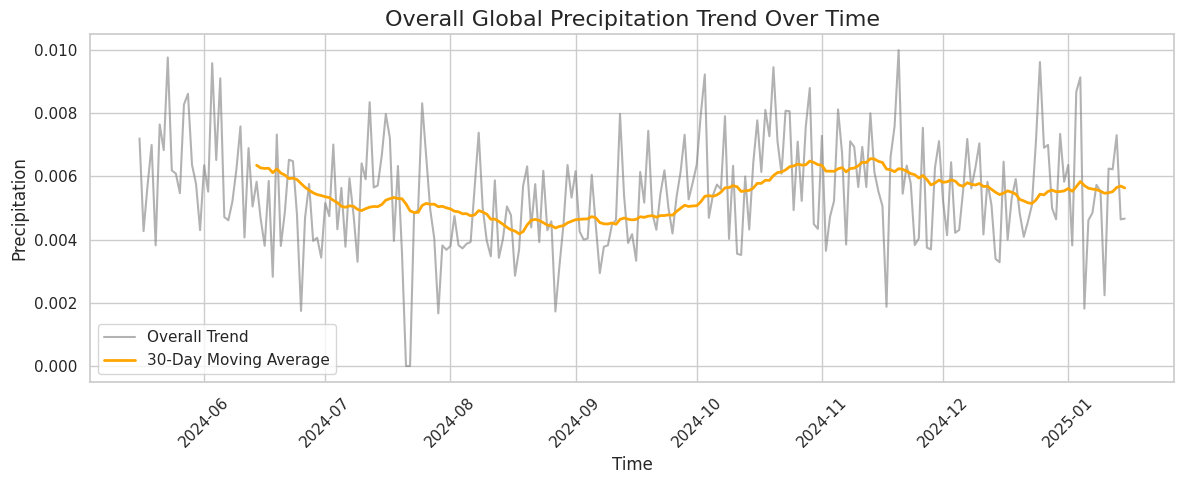

<Figure size 640x480 with 0 Axes>

time: 386 ms (started: 2025-01-16 01:13:22 +00:00)


In [18]:
# Filter for object columns
object_columns = df_no_outliers.select_dtypes(include='object')

# Resample to daily frequency by taking the mean of the temperature for each day
df_daily = df_no_outliers.drop(columns=object_columns)

df_daily = df_daily.resample('D').mean()

# Calculate the mean of the temperature celcius series (ignoring NaN)
mean_value = df_daily['precip_mm'].mean()

# Replace the specific value 7.1 with the mean
df_daily = df_daily.replace(7.1, mean_value)

# Forward fill
df_daily = df_daily.fillna(method='ffill')

# Calculate the rolling average
rolling_window = 30  # Set the window size (e.g., 30 days for a monthly average)
rolling_avg = df_daily['precip_mm'].rolling(window=rolling_window).mean()

# Plot the overall temperature trend with the rolling average
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# Plot the overall trend
plt.plot(
    df_daily.index, 
    df_daily['precip_mm'], 
    label="Overall Trend",
    alpha=0.6,
    color="grey"
)

# Plot the rolling average
plt.plot(
    df_daily.index, 
    rolling_avg, 
    label=f"{rolling_window}-Day Moving Average",
    color="orange",
    linewidth=2
)

# Add plot details
plt.title("Overall Global Precipitation Trend Over Time", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Precipitation", fontsize=12)
plt.xticks(rotation=45)
plt.legend()  # Add legend for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the plot
plt.savefig('../output/visuals/daily_global_precipitation_trends.png', dpi=300, bbox_inches='tight')

### UV Index Analysis

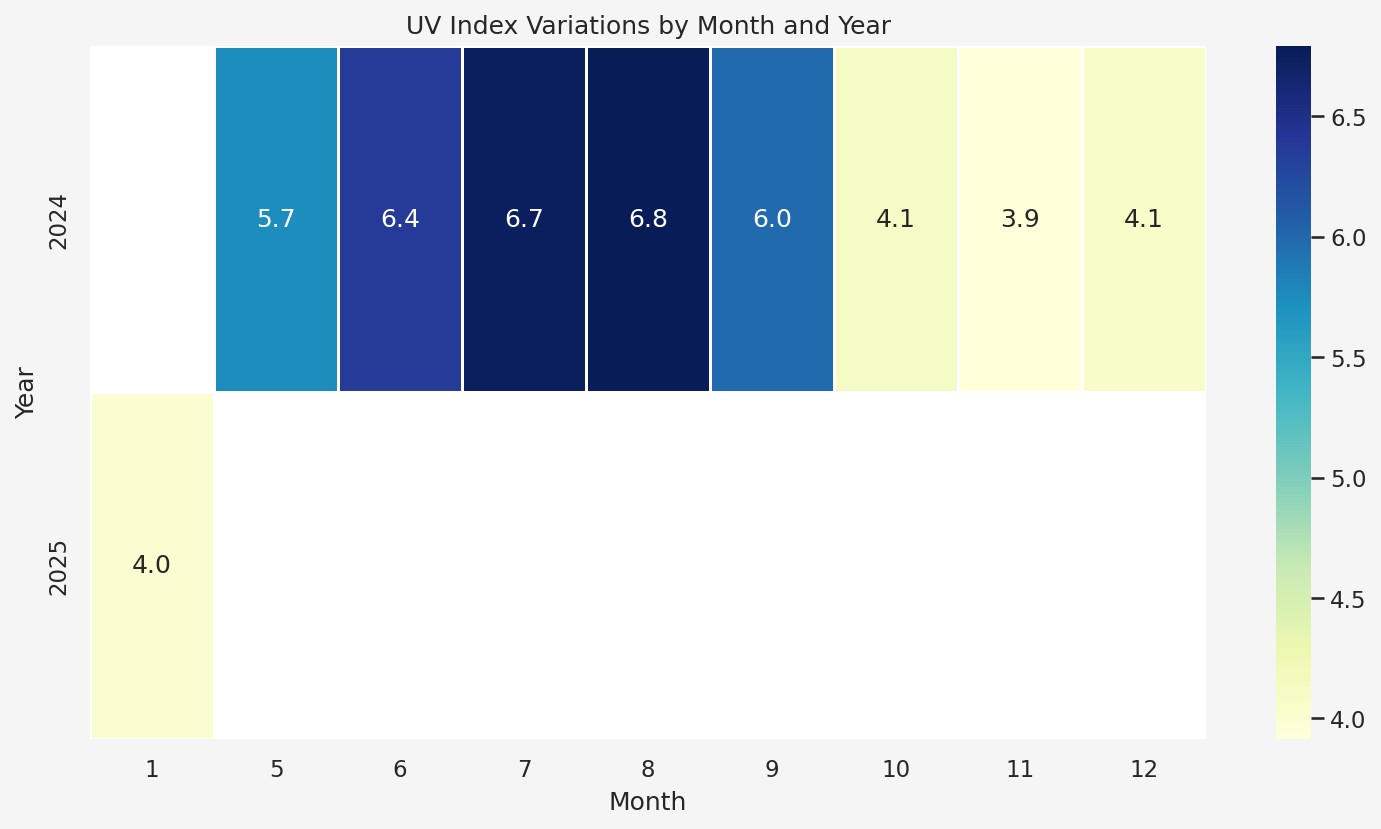

<Figure size 640x480 with 0 Axes>

time: 343 ms (started: 2025-01-16 02:11:21 +00:00)


In [65]:
# Heatmap to visualize UV index variations by month and year
uv_index_heatmap = df_no_outliers.pivot_table(values='uv_index', index='year', columns='month', aggfunc='mean')
plt.figure(figsize=(12, 6), dpi=150)
sns.heatmap(uv_index_heatmap, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)
plt.title('UV Index Variations by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.grid(False)
plt.show()
plt.savefig('../output/visuals/UV_index.png', dpi=300, bbox_inches='tight')

## Feature Engineering

Search for all 'object' data and convert it into numerical data
so that it can be used as a feature in machine learning models.

In [20]:
# Filter for object columns
object_columns = df_no_outliers.select_dtypes(include='object')

# Print unique values for each object column
for col in object_columns.columns:
    print(f"Unique values in column '{col}':")

Unique values in column 'country':
Unique values in column 'location_name':
Unique values in column 'timezone':
Unique values in column 'condition_text':
Unique values in column 'wind_direction':
Unique values in column 'sunrise':
Unique values in column 'sunset':
Unique values in column 'moonrise':
Unique values in column 'moonset':
Unique values in column 'moon_phase':
time: 4.93 ms (started: 2025-01-16 01:13:23 +00:00)


Preprocess country, location_name, condition, moon phase, and wind direction 
by converting text to lowercase, then encoding unique values into numeric
codes (0,1,2,...)

In [21]:
# Convert to lowercase
df_no_outliers['condition_text'] = df_no_outliers['condition_text'].str.lower()
df_no_outliers['moon_phase'] = df_no_outliers['moon_phase'].str.lower()
df_no_outliers['wind_direction'] = df_no_outliers['wind_direction'].str.lower()
df_no_outliers['country'] = df_no_outliers['country'].str.lower()
df_no_outliers['location_name'] = df_no_outliers['location_name'].str.lower()
df_no_outliers['timezone'] = df_no_outliers['timezone'].str.lower()


# Get unique values and assign numeric codes
df_no_outliers['condition_text'] = df_no_outliers['condition_text'].astype('category').cat.codes
df_no_outliers['moon_phase'] = df_no_outliers['moon_phase'].astype('category').cat.codes
df_no_outliers['wind_direction'] = df_no_outliers['wind_direction'].astype('category').cat.codes
df_no_outliers['country'] = df_no_outliers['country'].astype('category').cat.codes
df_no_outliers['location_name'] = df_no_outliers['location_name'].astype('category').cat.codes
df_no_outliers['timezone'] = df_no_outliers['timezone'].astype('category').cat.codes

time: 24.5 ms (started: 2025-01-16 01:13:23 +00:00)


Preprocess all time features into numerical data

In [22]:
def time_to_minutes(time_str):
    if time_str.lower() == 'no moonrise' or time_str.lower() == 'no moonset' or time_str.lower() == 'no sunrise' or time_str.lower() == 'no sunset':
        return -1  # or some other placeholder value (e.g., -1)
    try:
        time_obj = pd.to_datetime(time_str, format='%I:%M %p')  # Convert to datetime
        return time_obj.hour * 60 + time_obj.minute
    except ValueError:
        return None  # or handle other invalid time formats similarly

df_no_outliers['moonrise'] = df_no_outliers['moonrise'].apply(time_to_minutes)
df_no_outliers['moonset'] = df_no_outliers['moonset'].apply(time_to_minutes)
df_no_outliers['sunrise'] = df_no_outliers['sunrise'].apply(time_to_minutes)
df_no_outliers['sunset'] = df_no_outliers['sunset'].apply(time_to_minutes)

time: 5.41 s (started: 2025-01-16 01:13:23 +00:00)


In [23]:
df_no_outliers

country  location_name  latitude  longitude  timezone  \
last_updated                                                                 
2024-05-16 02:45:00      111            110   12.1500   -86.2700        62   
2024-05-16 02:45:00       16             36   17.2500   -88.7700        47   
2024-05-16 03:45:00      119            141    8.9700   -79.5300        67   
2024-05-16 03:45:00      121             99  -12.0500   -77.0500        61   
2024-05-16 04:45:00       63            164   12.0500   -61.7500        54   
...                      ...            ...       ...        ...       ...   
2025-01-15 15:15:00       96             64    6.8833    73.1000       163   
2025-01-15 15:45:00       18            185   27.4833    89.6000       113   
2025-01-15 16:45:00      155            129   18.7833   100.7833        84   
2025-01-15 17:30:00       27            146   11.5500   104.9167       103   
2025-01-15 19:15:00      122            112   14.6042   120.9822       101   

                     temperature_celsius  temperature_fahrenheit  \
last_updated                                                       
2024-05-16 02:45:00                 27.2                    80.9   
2024-05-16 02:45:00                 26.0                    78.9   
2024-05-16 03:45:00                 26.0                    78.8   
2024-05-16 03:45:00                 16.6                    61.9   
2024-05-16 04:45:00                 28.0                    82.4   
...                                  ...                     ...   
2025-01-15 15:15:00                 27.2                    80.9   
2025-01-15 15:45:00                 11.0                    51.7   
2025-01-15 16:45:00                 28.2                    82.8   
2025-01-15 17:30:00                 31.2                    88.2   
2025-01-15 19:15:00                 26.6                    79.9   

                     condition_text  wind_mph  wind_kph  ...  sunrise  sunset  \
last_updated                                             ...                    
2024-05-16 02:45:00              14       3.6       5.8  ...      321    1082   
2024-05-16 02:45:00              10       4.3       6.8  ...      323    1100   
2024-05-16 03:45:00              10       2.2       3.6  ...      358    1111   
2024-05-16 03:45:00              11       7.4      11.9  ...      378    1071   
2024-05-16 04:45:00              11      13.6      22.0  ...      343    1104   
...                             ...       ...       ...  ...      ...     ...   
2025-01-15 15:15:00              10      14.5      23.4  ...      384    1090   
2025-01-15 15:45:00              16       5.8       9.4  ...      413    1049   
2025-01-15 16:45:00              16       2.5       4.0  ...      413    1080   
2025-01-15 17:30:00              11       8.9      14.4  ...      384    1076   
2025-01-15 19:15:00              14       7.2      11.5  ...      385    1066   

                     moonrise  moonset  moon_phase  moon_illumination  year  \
last_updated                                                                  
2024-05-16 02:45:00       769       49           7                 55  2024   
2024-05-16 02:45:00       776       64           7                 55  2024   
2024-05-16 03:45:00       804       78           7                 55  2024   
2024-05-16 03:45:00       810       47           7                 55  2024   
2024-05-16 04:45:00       788       68           7                 55  2024   
...                       ...      ...         ...                ...   ...   
2025-01-15 15:15:00      1176      451           5                 99  2025   
2025-01-15 15:45:00      1133      481           5                 99  2025   
2025-01-15 16:45:00      1163      478           5                 99  2025   
2025-01-15 17:30:00      1157      448           5                 99  2025   
2025-01-15 19:15:00      1145      447           5                 99  2025   

                     month  day  hour  

time: 15.9 ms (started: 2025-01-16 01:13:28 +00:00)


## Data Normalization

In [24]:
# Move temperature_celciuse into last

cols = [col for col in df_no_outliers.columns if col != 'temperature_celsius']  # All columns except 'temperature_celsius'
df_no_outliers = df_no_outliers[cols + ['temperature_celsius']]  # Reorder columns, placing 'temperature_celsius' at the end

time: 3.76 ms (started: 2025-01-16 01:13:28 +00:00)


In [25]:
# Define the scale pipeline
features = df_no_outliers.columns
scaler = ColumnTransformer(
    transformers=[('scaler', RobustScaler(), features)]
)

# Fit and transform the data
values = scaler.fit_transform(df_no_outliers)

time: 40.6 ms (started: 2025-01-16 01:13:28 +00:00)


## Data Preprocessing

In [26]:
n_steps_in = 120
n_steps_out = 1

def preprocess_data(values_array, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess a single dataset for training.
    
    Args:
        values_array: Numpy array containing time series data with features
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    
    # 1. Prepare data
    # Remove 'Close Next Day' from features (last column)
    features = values_array[:, :-1]  # All columns except the last one
    targets = values_array[:, -1]    # Only the last column
    
    # 2. Split into train/validation
    n_train = int(len(features) * train_split)
    
    # Ensure we have enough data for both training and validation
    if n_train <= n_steps_in + n_steps_out:
        raise ValueError(f"Insufficient data. Need more than {n_steps_in + n_steps_out} samples.")
    
    # Split features and targets
    train_features = features[:n_train]
    train_targets = targets[:n_train]
    val_features = features[n_train:]
    val_targets = targets[n_train:]
    
    # 4. Create sequences
    train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
    val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y = preprocess_data(values, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(15971, 120, 42), y=(15971, 1)
Validation shapes: X=(3903, 120, 42), y=(3903, 1)
Number of features: 42
time: 3.67 s (started: 2025-01-16 01:13:28 +00:00)


## Model Training

#### Models Overview
1. **LSTM Model**:
   - Sequence-based deep learning model.
   - Architecture includes an LSTM layer (32 units) and a Dense output layer.
   - Optimized using Adam optimizer and MSE as the loss function.
   - Early stopping applied to prevent overfitting.

2. **GRU Model**:
   - Similar structure to the LSTM model but uses a GRU layer instead.
   - Early stopping used for efficient training.

3. **XGBoost Model**:
   - Gradient boosting algorithm for regression tasks.
   - Input data reshaped into 2D format.
   - Key hyperparameters: 100 estimators, max depth of 6, learning rate 0.1, and subsample ratios of 0.8.

In [27]:
tf.keras.backend.clear_session()

def build_lstm_model(n_steps_in, n_features, n_steps_out):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    model.compile(optimizer=optimizer, loss=['mse'])
    model.summary()
    
    return model

# Create and train model
lstm_model = build_lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

2025-01-16 01:13:32.393880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


2025-01-16 01:13:32.751034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 01:13:32.751210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 01:13:32.752796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                9600      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 9633 (37.63 KB)
Trainable params: 9633 (37.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 3.7 s (started: 2025-01-16 01:13:32 +00:00)


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

history = lstm_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=32,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping],
)

lstm_model.save('../output/model/lstm_model.keras')

Epoch 1/100


2025-01-16 01:13:48.848745: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fef38012db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-16 01:13:48.848787: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-01-16 01:13:48.875924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-16 01:13:49.343993: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1736990029.448891     856 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 - 49s - loss: 0.5678 - val_loss: 1.1067 - 49s/epoch - 98ms/step
Epoch 2/100
500/500 - 38s - loss: 0.5551 - val_loss: 1.0865 - 38s/epoch - 77ms/step
Epoch 3/100
500/500 - 39s - loss: 0.5489 - val_loss: 1.0825 - 39s/epoch - 77ms/step
Epoch 4/100
500/500 - 38s - loss: 0.5442 - val_loss: 1.0827 - 38s/epoch - 77ms/step
Epoch 5/100
500/500 - 38s - loss: 0.5401 - val_loss: 1.0847 - 38s/epoch - 76ms/step
Epoch 6/100
500/500 - 39s - loss: 0.5365 - val_loss: 1.0878 - 39s/epoch - 79ms/step
Epoch 7/100
500/500 - 40s - loss: 0.5332 - val_loss: 1.0915 - 40s/epoch - 79ms/step
Epoch 8/100
500/500 - 39s - loss: 0.5302 - val_loss: 1.0956 - 39s/epoch - 79ms/step
Epoch 9/100
500/500 - 39s - loss: 0.5274 - val_loss: 1.0995 - 39s/epoch - 79ms/step
Epoch 10/100
500/500 - 40s - loss: 0.5249 - val_loss: 1.1031 - 40s/epoch - 80ms/step
Epoch 11/100
500/500 - 40s - loss: 0.5225 - val_loss: 1.1066 - 40s/epoch - 80ms/step
Epoch 12/100
500/500 - 40s - loss: 0.5203 - val_loss: 1.1097 - 40s/epoch - 80ms/step
E

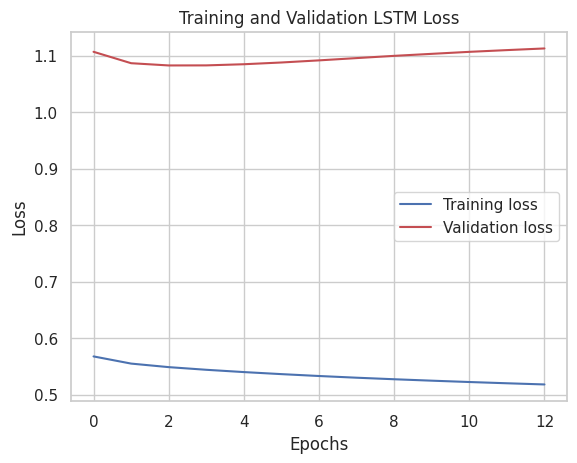

time: 189 ms (started: 2025-01-16 01:23:07 +00:00)


In [29]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation LSTM Loss")

In [30]:
tf.keras.backend.clear_session()

def build_gru_model(n_steps_in, n_features, n_steps_out):
    model = Sequential([
        GRU(32, activation='relu', input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    model.compile(optimizer=optimizer, loss=['mse'])
    model.summary()
    
    return model

# Create and train model
gru_model = build_gru_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

history_gru = gru_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=32,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping],
)

gru_model.save('../output/model/gru_model.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                7296      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7329 (28.63 KB)
Trainable params: 7329 (28.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
500/500 - 57s - loss: 0.6096 - val_loss: 1.1266 - 57s/epoch - 115ms/step
Epoch 2/100
500/500 - 53s - loss: 0.5765 - val_loss: 1.1055 - 53s/epoch - 106ms/step
Epoch 3/100
500/500 - 53s - loss: 0.5650 - val_loss: 1.0985 - 53s/epoch - 106ms/step
Epoch 4/100
500/500 - 52s - loss: 0.5583 - val_loss: 1.0970 - 52s/epoch - 105ms/step
Epoch 5/100
500/500 - 52s - loss: 0.5533 - val_loss: 1.0982 - 52s/epoch - 104m

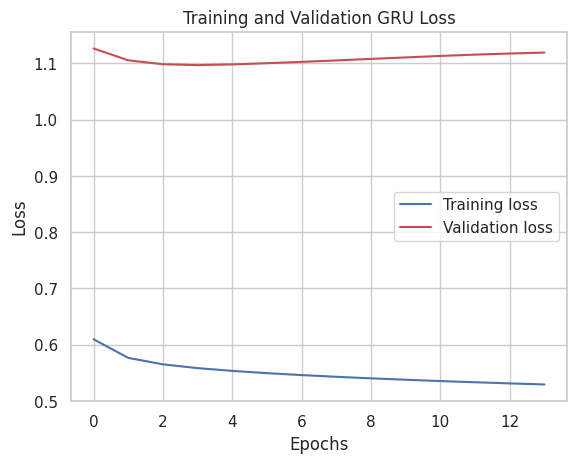

time: 297 ms (started: 2025-01-16 01:35:33 +00:00)


In [31]:
visualize_loss(history_gru, "Training and Validation GRU Loss")

In [32]:
from xgboost import XGBRegressor

# Reshape the data to 2D: (samples, features)
train_X_reshaped = train_X.reshape(train_X.shape[0], -1)  # (15971, 120 * 42)
val_X_reshaped = val_X.reshape(val_X.shape[0], -1)        # (3903, 120 * 42)

# Initialize the XGBRegressor model
xgb_model = XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Learning rate
    max_depth=6,           # Maximum depth of trees
    subsample=0.8,         # Subsample ratio of training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42        # Seed for reproducibility
)

# Train the model
xgb_model.fit(train_X_reshaped, train_y.ravel())

# Make predictions
val_predictions = xgb_model.predict(val_X_reshaped)

# Evaluate the model
mse = mean_squared_error(val_y, val_predictions)
print(f"Validation Mean Squared Error (MSE): {mse}")

Validation Mean Squared Error (MSE): 1.0855502513283948
time: 1min 4s (started: 2025-01-16 01:35:34 +00:00)


## Model Evaluation

**LSTM Model** achieved the lowest MSE (1.082546) and lowest MAE (0.836289) among all models.
Demonstrates superior accuracy in predicting the validation data.

**XGBRegressor** follows closely, suggesting it is also a strong candidate for the task, particularly if computational efficiency is a priority.

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions and evaluation for LSTM model
lstm_val_predictions = lstm_model.predict(val_X)
lstm_mse = mean_squared_error(val_y, lstm_val_predictions)
lstm_mae = mean_absolute_error(val_y, lstm_val_predictions)

# Predictions and evaluation for GRU model
gru_val_predictions = gru_model.predict(val_X)
gru_mse = mean_squared_error(val_y, gru_val_predictions)
gru_mae = mean_absolute_error(val_y, gru_val_predictions)


# Predictions and evaluation for Support Vector Regressor
xgb_val_predictions = xgb_model.predict(val_X_reshaped)
xgb_mse = mean_squared_error(val_y, xgb_val_predictions)
xgb_mae = mean_absolute_error(val_y, xgb_val_predictions)


# Create a dictionary with the evaluation results
model_comparison = {
    "Model": ["XGBRegressor", "LSTM Model", "GRU Model"],
    "MSE": [xgb_mse, lstm_mse, gru_mse],
    "MAE": [xgb_mae, lstm_mae, gru_mae]
}

# Convert the dictionary to a Pandas DataFrame
result_df = pd.DataFrame(model_comparison)

# Display the DataFrame
print("\nModel Comparison:")
print(result_df)

122/122 [==============================] - 2s 18ms/step

Model Comparison:
          Model       MSE       MAE
0  XGBRegressor  1.085550  0.842187
1    LSTM Model  1.082546  0.836289
2     GRU Model  1.096963  0.843680
time: 8.55 s (started: 2025-01-16 01:37:34 +00:00)


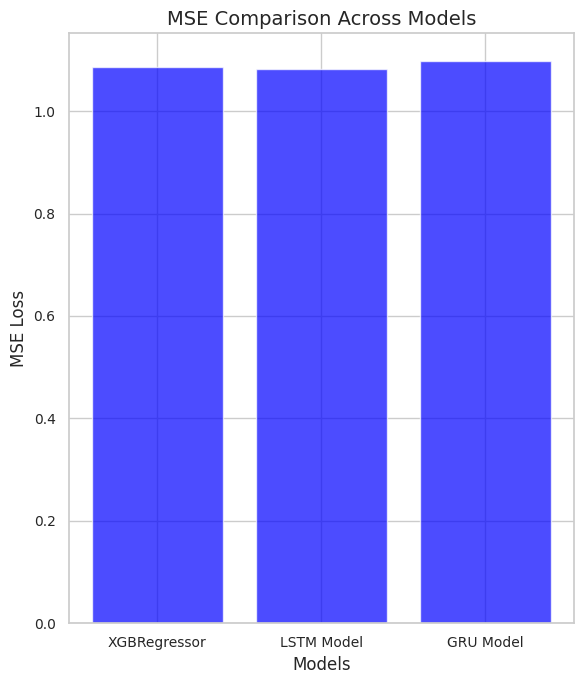

<Figure size 640x480 with 0 Axes>

time: 277 ms (started: 2025-01-16 01:39:42 +00:00)


In [39]:
# MSE Bar Chart with Log Scale
plt.figure(figsize=(6, 7))
plt.bar(result_df['Model'], result_df['MSE'], color='blue', alpha=0.7)
plt.title('MSE Comparison Across Models', fontsize=14)
plt.ylabel('MSE Loss', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.savefig('../output/visuals/mse_comparison.png', dpi=300, bbox_inches='tight')

## Prediction of Global Temperature (Celsius) for the Next Hour

In [50]:
def get_next_hour_prediction(model, last_sequence, scaler, feature_columns):
    """
    Get temperature prediction for the next hour using the trained model.
    
    Args:
        model: Trained model (LSTM, GRU, or XGBoost)
        last_sequence: Last n_steps_in days of data (shaped according to model requirements)
        scaler: Fitted ColumnTransformer scaler used during training
        feature_columns: List of feature column names
        
    Returns:
        float: Predicted temperature for the next day
    """
    # Ensure the input sequence is properly shaped
    if isinstance(model, XGBRegressor):
        # For XGBoost, reshape to 2D
        prediction_input = last_sequence.reshape(1, -1)
    else:
        # For LSTM/GRU, keep 3D shape (samples, timesteps, features)
        prediction_input = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])
    
    # Make prediction
    prediction = model.predict(prediction_input)
    
    # Get the RobustScaler from the ColumnTransformer
    robust_scaler = scaler.named_transformers_['scaler']
    
    # Create a dummy array with the same shape as the original data
    dummy_array = np.zeros((1, len(feature_columns)))
    dummy_array[0, -1] = prediction[0]  # Put the prediction in the target column
    
    # Inverse transform using the RobustScaler
    prediction_unscaled = robust_scaler.inverse_transform(dummy_array)[0, -1]
    
    return prediction_unscaled

# Get the last sequence from your validation data
last_known_sequence = val_X[-1]

# Get predictions from each model
# LSTM prediction
lstm_next_day = get_next_day_prediction(
    lstm_model, 
    last_known_sequence,
    scaler,
    features
)

# GRU prediction
gru_next_day = get_next_day_prediction(
    gru_model,
    last_known_sequence,
    scaler,
    features
)

# XGBoost prediction
# Reshape the sequence for XGBoost
last_sequence_reshaped = last_known_sequence.reshape(1, -1)
xgb_next_day = get_next_day_prediction(
    xgb_model,
    last_sequence_reshaped,
    scaler,
    features
)

# Create an ensemble prediction (simple average)
ensemble_prediction = np.mean([lstm_next_day, gru_next_day, xgb_next_day])

# Print predictions
print("\nNext hour Temperature Predictions:")
print(f"LSTM: {lstm_next_day:.2f}°")
print(f"GRU: {gru_next_day:.2f}°")
print(f"XGBoost: {xgb_next_day:.2f}°")
print(f"Ensemble Average: {ensemble_prediction:.2f}°")

1/1 [==============================] - 0s 30ms/step

Next hour Temperature Predictions:
LSTM: 21.86°
GRU: 23.48°
XGBoost: 24.80°
Ensemble Average: 23.38°
time: 132 ms (started: 2025-01-16 01:56:54 +00:00)


/tmp/ipykernel_793/3791002478.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy_array[0, -1] = prediction[0]  # Put the prediction in the target column
/tmp/ipykernel_793/3791002478.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy_array[0, -1] = prediction[0]  # Put the prediction in the target column


1/1 [==============================] - 0s 31ms/step


/tmp/ipykernel_793/113732357.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy_array[0, -1] = pred
/tmp/ipykernel_793/113732357.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy_array[0, -1] = pred


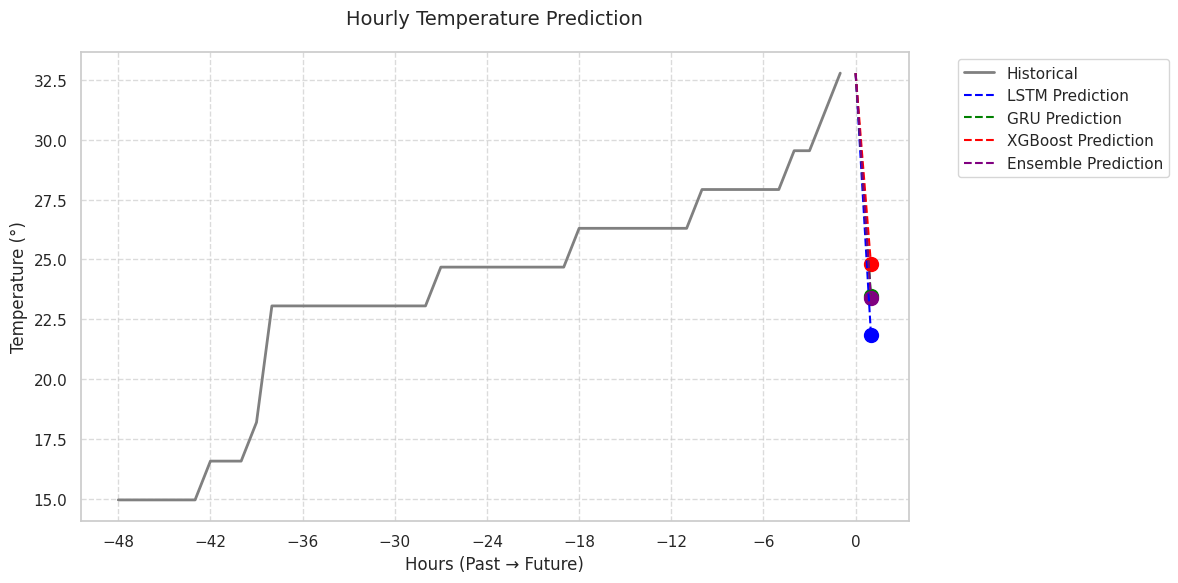

<Figure size 640x480 with 0 Axes>

time: 471 ms (started: 2025-01-16 01:57:27 +00:00)


In [53]:
from datetime import datetime, timedelta

def visualize_hourly_predictions(models, last_sequence, scaler, features, history_hours=48):
    """
    Visualize the last N hours of actual data and predicted next hour temperature.
    
    Args:
        models: Dictionary of models {'name': model_object}
        last_sequence: Last sequence of data used for prediction
        scaler: Fitted ColumnTransformer scaler
        features: List of feature column names
        history_hours: Number of past hours to display (default: 48)
    """
    # Get the RobustScaler from the ColumnTransformer
    robust_scaler = scaler.named_transformers_['scaler']
    
    # Create figure and axis with larger size
    plt.figure(figsize=(12, 6))
    
    # Plot historical data
    historical_data = last_sequence[-history_hours:, -1]  # Get last column (temperature)
    historical_times = np.arange(-history_hours, 0)
    
    # Inverse transform historical data
    historical_data_reshaped = np.zeros((len(historical_data), len(features)))
    historical_data_reshaped[:, -1] = historical_data
    historical_data_unscaled = robust_scaler.inverse_transform(historical_data_reshaped)[:, -1]
    
    # Plot historical data
    plt.plot(historical_times, historical_data_unscaled, 
             label='Historical', color='gray', linewidth=2)
    
    # Get and plot predictions for each model
    colors = ['blue', 'green', 'red']
    predictions = []
    
    for (name, model), color in zip(models.items(), colors):
        # Reshape input based on model type
        if isinstance(model, XGBRegressor):
            prediction_input = last_sequence.reshape(1, -1)
        else:
            prediction_input = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])
            
        # Get prediction
        pred = model.predict(prediction_input)[0]
        
        # Inverse transform prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, -1] = pred
        pred_unscaled = robust_scaler.inverse_transform(dummy_array)[0, -1]
        predictions.append(pred_unscaled)
        
        # Plot prediction point
        plt.plot([0, 1], [historical_data_unscaled[-1], pred_unscaled],
                color=color, linestyle='--', label=f'{name} Prediction')
        plt.scatter([1], [pred_unscaled], color=color, s=100)
    
    # Calculate and plot ensemble prediction
    ensemble_pred = np.mean(predictions)
    plt.plot([0, 1], [historical_data_unscaled[-1], ensemble_pred],
            color='purple', linestyle='--', label='Ensemble Prediction')
    plt.scatter([1], [ensemble_pred], color='purple', s=100)
    
    # Customize the plot
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Hourly Temperature Prediction', fontsize=14, pad=20)
    plt.xlabel('Hours (Past → Future)', fontsize=12)
    plt.ylabel('Temperature (°)', fontsize=12)
    
    # Set x-axis ticks
    plt.xticks(np.arange(-history_hours, 2, 6))
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Create dictionary of models
models = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'XGBoost': xgb_model
}

# Visualize predictions
fig = visualize_hourly_predictions(
    models=models,
    last_sequence=last_known_sequence,
    scaler=scaler,
    features=features,
    history_hours=48  # Show last 48 hours
)

plt.show()
plt.savefig('../output/visuals/prediction_next_hour.png', dpi=300, bbox_inches='tight')